# Gauss-Newton example

In order to add additional functions you should 

1. Identify the functions $r_i$ in your case and put them into a Numpy array
2. Compute the Jacobian matrix: on line $i$ you have the partial derivatives of $r_i$ with respect to all variables

Note that the parameter `GN` in the `GDlinesearch` function allows you to switch between the Gauss-Newton direction and the anti-gradient one to compare the speed of convergence of the two algorithms.

Initial value: 270.2075246400002


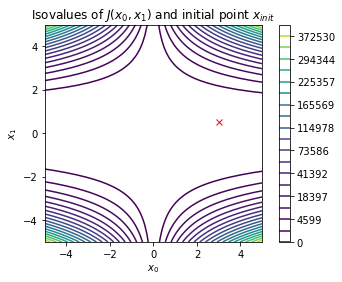

[-147.3732612  1000.96001192]


In [1]:
import numpy as np
import pylab as pl
# import scipy.optimize as sp
import matplotlib.pyplot as plt


x0 = np.array([-2.2,2.1])
d = [1,np.sqrt(2),1]
ants = [[0,0],[1,0],[0,1]]

mult = 1

m1 = 0.1
m2 = 0.9
Tol = 5e-16
Maxiter = 2000

variant = 2

# least squares functions r_i
def r(x, d = None, a = None):
    if variant==1:
        return np.array([
            10*(x[1]-x[0]**2),1-x[0]
        ])
    elif variant==2:
        return np.array([1.5-x[0]+x[0]*x[1],2.25-x[0]+x[0]*x[1]**2,2.625-x[0]+x[0]*x[1]**3])
    elif variant==3:
        return np.array([[d[i] - np.sqrt((x[0]-ant[i][0])**2 + (x[1]-ant[i][1])**2)] for i in range(3)])

# compute Jacobian matrix: on each line the partial derivatives w.r.t one of the variables
def Jac(x):
    if variant==1:
        return np.array([
            [-20*x[0],10],
            [-1,0]
        ])
    elif variant ==2:
        return np.array([[-1+x[1],x[0]], [-1+x[1]**2, 2*x[0]*x[1]], [-1+x[1]**3,3*x[0]*x[1]**3]])
    elif variant ==3:
        return np.array([[-(x[0]-ant[i][0])/(np.sqrt((x[0]-ant[i][0])**2 + (x[1]-ant[i][1])**2)), 
                         -(x[1]-ant[i][1])/(np.sqrt((x[0]-ant[i][0])**2 + (x[1]-ant[i][1])**2))] for i in range(3)])

    
# print(sp.check_grad(r,Jac,x0))
# objective function: sum of squares of r_i    
def J(x):
        res = r(x);
        return sum(res**2)
        
# gradient        
def GradJ(x):
        res = r(x)
        Jr  = Jac(x)
        return Jr.T@res
    
# Gauss-Newton direction    
def GNdir(x):
        res = r(x)
        Jr  = Jac(x)
        Mat = Jr.T@Jr
        try:
            d = -np.linalg.solve(Mat,Jr.T@res)
            return d
        except:
            print("could not invert GN matrix")
            return Jr.T@res

if variant==1:
    analytic = [1,1]
if variant==2:
    analytic = [3,0.5]
if variant==3:
    analytic = []

print("Initial value:",J(x0))

plt.figure()
xmin=min(-4,analytic[0])-1
xmax=max(4,analytic[0])+1
ymin=min(-4,analytic[1])-1
ymax=max(4,analytic[1])+1
aX0=np.linspace(xmin,xmax,100)
aX1=np.linspace(ymin,ymax,100)
Z=np.array([[J(np.array([x0,x1])) for x0 in aX0] for x1 in aX1])

contours = np.linspace(0,Z.max()**(1/2),20)**2
plt.contour(aX0,aX1,Z,levels=contours)#(np.linspace(0,30,10)**2))
plt.plot(analytic[0],analytic[1],'rx')
plt.axis('scaled')
plt.colorbar()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Isovalues of $J(x_0,x_1)$ and initial point $x_{init}$')
plt.show()

print(GradJ(x0))

In [2]:
def GDlinesearch(f,df,x0,tol,maxiter,m1,m2,GN=1):
    phist = []
    vhist = []
    ghist = []
    phist.append(x0)            # Create an array which holds the optimization history
 
    val = f(x0)
    gd   = df(x0)
    vhist.append(val)
    ghist.append(gd)
    iter = 0
    step = 0.1
    prevval = val
    d = gd
    while abs(np.linalg.norm(gd))>=Tol: 
        iter=iter+1
        #Line search
        tl=0
        tr=0
        t=1
        step=t
        # choice of the descent direction  
        if GN==1:
            d = GNdir(x0)
        else:
            d = -gd
    

        #np.sqrt(abs((f(x0+step*d,v)-val)))/step<np.sqrt(abs(-(m1*(d*d))))
        while (1==1):
            qt = f(x0+t*d)
            qp = np.dot(gd,d)
            qd = df(x0+t*d)
            #print(tl," ",tr)
            if ((qt-val)/t<=(m1*qp)) and (np.dot(qd,d)>=(m2*qp)):
                step=t   # we found a good step
                break
            if ((qt-val)/t>(m1*qp)):
                # step too big
                tr = t
            if ((qt-val)/t<(m2*qp)):
                # step too small
                tl = t
            if(tr==0):
                t = 2*tl
            else:
                t = 0.5*(tl+tr)
            if abs(tr-tl)<1e-15*tr or tr<1e-15:
                break
        if(np.linalg.norm(step*d)/np.linalg.norm(x0)<Tol):
            print("Too small change!")
            #d = -gd
            #step = 0.1
            break
        x0 = x0+step*(d)
        val = f(x0)
        gd   = df(x0)
        
        if(iter%10==0):
            print("Iter: ",iter,"| Val: ",val,"| Step: ",step," Grad: ",abs(np.linalg.norm(gd)))
        phist.append(x0)
        vhist.append(val)
        ghist.append(d)
        if(iter>maxiter):
            print('Maximum number of iterations reached!')
            break
        #if(abs(val-prevval)<Tol):
            #print('Function does not decrease enough!')
            #break
        prevval = val
    if(np.linalg.norm(d)<Tol): 
        print('Algorithm converged!')
    print('')
    print('Final output:')
    print("Iter: ",iter,"| Val: ",val,"| Step: ",step," Grad: ",abs(np.linalg.norm(gd)))
    return phist,vhist,ghist

In [3]:
pp,vv,gg = GDlinesearch(J,GradJ,x0,Tol,Maxiter,m1,m2,GN=1)

print('Number of iterations: ',len(pp))
print('Final position: ',pp[-1])
print('Difference to analytical sol: ',np.linalg.norm(analytic-pp[-1]))



Iter:  10 | Val:  0.7928385901916639 | Step:  0.03125  Grad:  15.209404022181516
Iter:  20 | Val:  0.7178319831187002 | Step:  0.0078125  Grad:  30.116273376156776
Iter:  30 | Val:  0.693475870405961 | Step:  0.00390625  Grad:  45.792332664513616
Iter:  40 | Val:  0.6818392471469521 | Step:  0.001953125  Grad:  61.51730417835415
Iter:  50 | Val:  0.6745730134391352 | Step:  0.001953125  Grad:  78.07465287912775
Iter:  60 | Val:  0.6699568516455653 | Step:  0.0009765625  Grad:  92.94766326100725
Iter:  70 | Val:  0.6668242913552821 | Step:  0.0009765625  Grad:  110.59786382348854
Iter:  80 | Val:  0.664290958613391 | Step:  0.00048828125  Grad:  124.56354999431146
Iter:  90 | Val:  0.6620477055865455 | Step:  0.00048828125  Grad:  139.16007528080863
Iter:  100 | Val:  0.6607604991499489 | Step:  0.00048828125  Grad:  157.97753583318266
Iter:  110 | Val:  0.6596041207652892 | Step:  0.000244140625  Grad:  173.02438911449292
Iter:  120 | Val:  0.658353021166178 | Step:  0.000244140625  Gr

Iter:  970 | Val:  0.6483537173344353 | Step:  3.814697265625e-06  Grad:  1514.998125001016
Iter:  980 | Val:  0.6483372078904437 | Step:  3.814697265625e-06  Grad:  1530.182352841441
Iter:  990 | Val:  0.6483212801368042 | Step:  3.814697265625e-06  Grad:  1545.6760225508929
Iter:  1000 | Val:  0.6483059518526296 | Step:  3.814697265625e-06  Grad:  1561.4886934116337
Iter:  1010 | Val:  0.648291241554209 | Step:  3.814697265625e-06  Grad:  1577.6303226245527
Iter:  1020 | Val:  0.6482771685320303 | Step:  3.814697265625e-06  Grad:  1594.1112862262316
Iter:  1030 | Val:  0.6482637528980109 | Step:  3.814697265625e-06  Grad:  1610.942401373264
Iter:  1040 | Val:  0.6482510156241024 | Step:  3.814697265625e-06  Grad:  1628.13495001788
Iter:  1050 | Val:  0.6482389785895408 | Step:  3.814697265625e-06  Grad:  1645.7007041422266
Iter:  1060 | Val:  0.6482276646317988 | Step:  3.814697265625e-06  Grad:  1663.651952686681
Iter:  1070 | Val:  0.6482170975994485 | Step:  3.814697265625e-06  Gr

Iter:  1850 | Val:  0.6476898451679496 | Step:  9.5367431640625e-07  Grad:  2899.300841941373
Iter:  1860 | Val:  0.6476850753876249 | Step:  9.5367431640625e-07  Grad:  2913.1231957036102
Iter:  1870 | Val:  0.6476803682418729 | Step:  9.5367431640625e-07  Grad:  2927.078418613288
Iter:  1880 | Val:  0.6476757246383774 | Step:  9.5367431640625e-07  Grad:  2941.1684360722784
Iter:  1890 | Val:  0.6476711454945514 | Step:  9.5367431640625e-07  Grad:  2955.395210829062
Iter:  1900 | Val:  0.647666631745449 | Step:  9.5367431640625e-07  Grad:  2969.7607438992327
Iter:  1910 | Val:  0.647662184349149 | Step:  9.5367431640625e-07  Grad:  2984.26707558006
Iter:  1920 | Val:  0.6476578042830572 | Step:  9.5367431640625e-07  Grad:  2998.916286397578
Iter:  1930 | Val:  0.6476534925352337 | Step:  9.5367431640625e-07  Grad:  3013.7104979557125
Iter:  1940 | Val:  0.6476492501290919 | Step:  9.5367431640625e-07  Grad:  3028.651874252602
Iter:  1950 | Val:  0.6476450780925506 | Step:  9.536743164

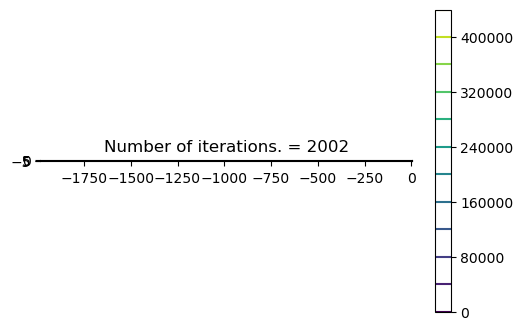

In [4]:
plt.figure(dpi=100)
#print(vv)
aX0=np.linspace(xmin,xmax)
aX1=np.linspace(ymin,ymax)
Z=np.array([[J(np.array([x0,x1])) for x0 in aX0] for x1 in aX1])
plt.contour(aX0,aX1,Z,12)

lx0=[X[0] for X in pp]
lx1=[X[1] for X in pp]
plt.plot(lx0,lx1,"-ro")

plt.plot(analytic[0],analytic[1],'-bx')


plt.axis('scaled')
plt.title('Number of iterations. = '+str(np.shape(lx0)[0]))
plt.colorbar()


plt.show()

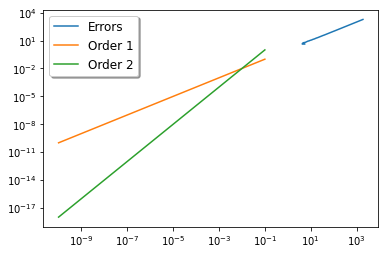

In [5]:
Niter = len(pp)
dis = np.linspace(1,Niter,Niter+1)

errors=[np.sqrt((X[0]-analytic[0])**2+(X[1]-analytic[1])**2) for X in pp]
#print(errors)

if(dis.size>10):
    dis2 = dis[0:10]
else:
    dis2 = dis
sq  = 0.1**dis2
lam = 0.5*(1+np.sqrt(5))
sq2 = 100*sq**2
sq3 = 100*sq**3
sqlam = 100*sq**lam

plt.figure()
#fig, ax = plt.subplots()

plt.loglog(errors[:-1:],errors[1:],label='Errors')
plt.loglog(sq,sq,label='Order 1')

plt.loglog(sq,sq2,label='Order 2')
#plt.loglog(sq,sq3,label='Order 3')

plt.legend(loc='best', shadow=True, fontsize='large')
plt.show()